In [12]:
#Manipulacion de datos
import pandas as pd
import numpy as np

#Visualizacion
import missingno as miss

#Funciones creadas
from funciones import *

#Evitar Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
#Accuracy y RMSLE
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error


#Modelos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


Carga de los CSV con Pandas

In [14]:
csv_train = pd.read_csv("Housing Dreams/house_train_raw.csv",encoding='latin-1')
csv_test = pd.read_csv("Housing Dreams/houses_test_raw.csv",encoding='latin-1')

Eliminamos las columnas Object de nuestro DataSet

In [15]:
dropear_columnas_object(csv_train)

dropear_columnas_object(csv_test)

Utilizo Missingo para ver donde esta la mayor cantidad de valores faltantes

<AxesSubplot:>

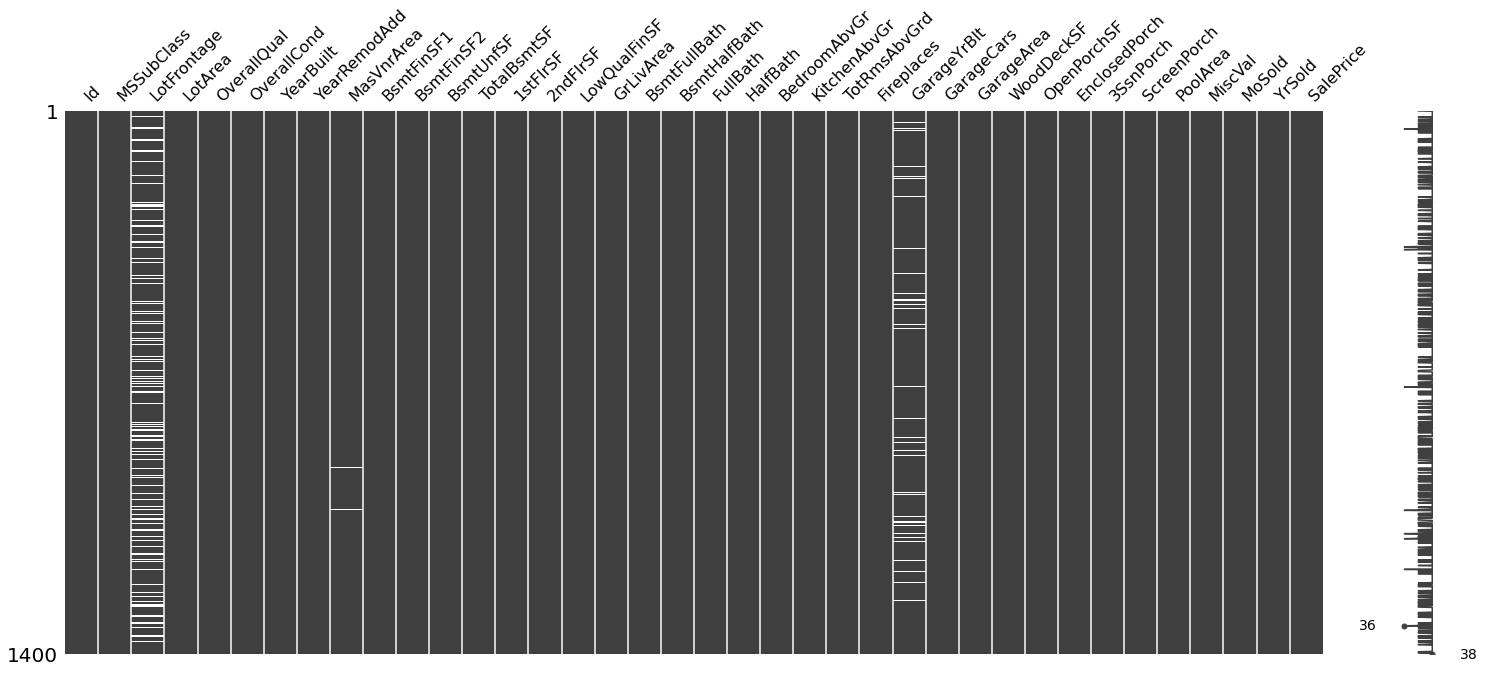

In [16]:
miss.matrix(csv_train.sample(1400))

Veo la correlacion de las columnas con la variable a predecir(SalePrice)

In [17]:
csv_train.corr()['SalePrice']

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

Hacemos una lista con las columnas que tengan mayor correlacion con la variable a predecir(SalePrice), para luego filtrarlas por estas

In [18]:
lista = []
for i in csv_train.corr()['SalePrice'].index:
    if csv_train.corr()['SalePrice'][i] < -0.6 or csv_train.corr()['SalePrice'][i] > 0.6 :
        lista.append(i)
        
lista.remove('SalePrice')

In [19]:
lista

['OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'GarageCars',
 'GarageArea']

Las columnas con datos faltantes no poseen una alta correlacion con la variable objetivo asi que tratar los valores nulos con el promedio de cada columna no afectara el modelo, ya que se filtraran luego

In [20]:
llenar_nulos_promedio(csv_test)

llenar_nulos_promedio(csv_train)

Creamos los X_train y X_test con las columnas con mayor correlacion, y creamos y_train con la variable a predecir

In [21]:
X_train = csv_train[lista]
y_train = csv_train['SalePrice']

X_test = csv_test[lista]


Utilizamos 6 modelos distintos para ver el rendimiento que tiene cada uno

In [22]:
modelos_class = {
    "Logit": LogisticRegression(),
    "DecTree": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "AdaBoostC": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
}

In [23]:
for name, model in modelos_class.items():
    print("Modelo",name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(f"RMSLE :",mean_squared_log_error(y_train, y_pred_train,squared=False))
    accuracy=accuracy_score(y_train, y_pred_train)
    print("Accuracy de Train :",accuracy)

Modelo Logit
RMSLE : 0.4506488910414432
Accuracy de Train : 0.03287671232876712
Modelo DecTree
RMSLE : 0.019322955728005242
Accuracy de Train : 0.9719178082191781
Modelo RFC
RMSLE : 0.016415725954493286
Accuracy de Train : 0.9719178082191781
Modelo AdaBoostC
RMSLE : 0.29869500477576194
Accuracy de Train : 0.01780821917808219
Modelo XGBoost
[11:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMSLE : 0.14617188632801065
Accuracy de Train : 0.8246575342465754
Modelo LightGBM
RMSLE : 0.4125140637015846
Accuracy de Train : 0.08835616438356164


Utilizamos el modelo Voting Classifier para combinar los modelos con mayor puntaje

In [24]:
from sklearn.ensemble import VotingClassifier

estimators = [
  ("DecTree",DecisionTreeClassifier()),
  ("RFC",RandomForestClassifier()),
  ("XGBoost",XGBClassifier())
]

vc = VotingClassifier(estimators=estimators)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_train = vc.predict(X_train)
print(f"RMSLE :",mean_squared_log_error(y_train, y_pred_train,squared=False))
accuracy=accuracy_score(y_train, y_pred_train)
print("Accuracy de Train :",accuracy)


[11:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMSLE : 0.01912891765721848
Accuracy de Train : 0.9719178082191781


Guardamos los resultados de las predicciones en un CSV

In [25]:
y_preds_train = pd.DataFrame()
y_preds_test = pd.DataFrame()

y_preds_train['train_pred'] = y_pred_train
y_preds_test['test_pred'] = y_pred


In [26]:
y_preds_train.to_csv('y_preds_train.csv')
y_preds_test.to_csv('y_preds_test.csv')